In [127]:
%load_ext autoreload
%autoreload 1
%aimport resource_networks
%aimport network_manipulation 


from resource_networks import *
from network_manipulation import *
from ipywidgets import interact, widgets

import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (10, 7)
plt.rcParams["axes.grid"] = True
plt.rcParams["font.size"] = 12
# import plotly.graph_objs as go
# import plotly.express as px

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
def plot_simulation(G, simulation):
    pl = G.plot_with_states(sim)
    f = lambda i: pl[i]
    interact(f, i=widgets.IntSlider(min=0,max=len(sim)-1,step=1,value=0, description='№ of iteration')) 
    return None

In [3]:
n = 7
G2 = ResourceDiGraph(nx.fast_gnp_random_graph(n, 0.2, directed=True))
sim = G2.run_simulation(np.random.randint(10, 13, size=n), 40)
plot_simulation(G2, sim)
# sim.arr

interactive(children=(IntSlider(value=0, description='№ of iteration', max=39), Output()), _dom_classes=('widg…

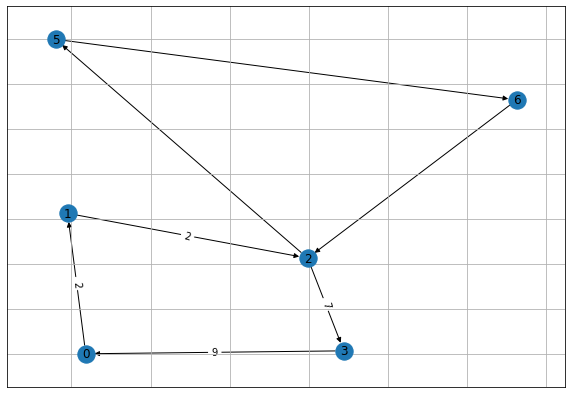

In [153]:
G1 = make_random_weights(nx.cycle_graph(4, create_using=nx.DiGraph))
G2 = nx.cycle_graph(3, create_using=nx.DiGraph)
draw_weighted(nx.contracted_nodes(nx.disjoint_union(G1, G2), 2, 4))

In [83]:
class A:
    def __init__(self, x, y):
        self.x = x
        self.y = y
class B(A):
    def __init__(self, *args, **kwargs):
        A.__init__(self, *args, **kwargs)
    @classmethod
    def from_parent(cls, parent):
        res = cls()
        res.super = parent
        return res
s = super(A, B)
dir(s)
s.__self_class__

__main__.B

In [52]:
list(nx.DiGraph(G2).edges)

[(0, 3), (1, 2)]

In [108]:
G2 = nx.DiGraph()
G2.add_edges_from(list(G_.edges(data=True)))
list(G2.edges(data=True))
# nx.draw_networkx(G2)

[(0, 3, {'weight': 0}), (1, 2, {'weight': 1})]

In [109]:
list(G2.edges(data=True))

[(0, 3, {'weight': 0}), (1, 2, {'weight': 1})]

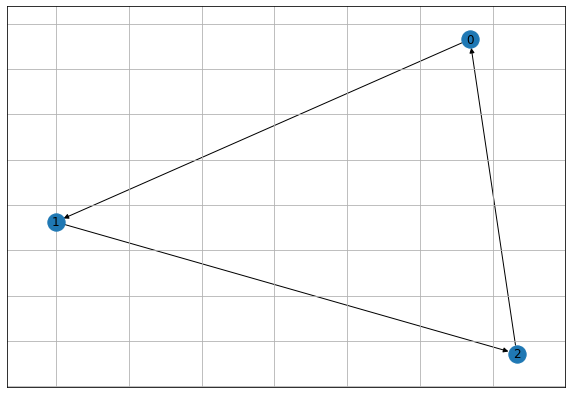

In [124]:
draw_weighted(G2)

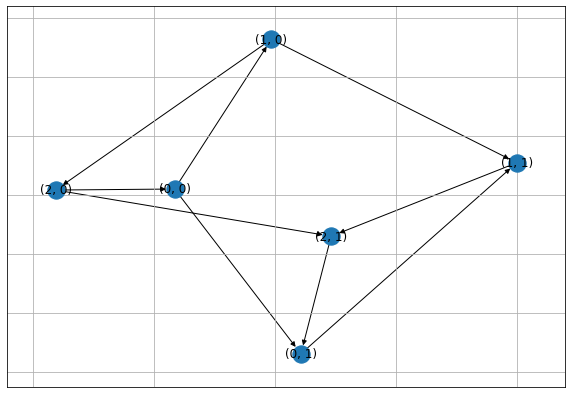

In [16]:
H = nx.cartesian_product(nx.cycle_graph(3, nx.DiGraph), nx.path_graph(2, nx.DiGraph))
nx.draw_networkx(H)

---

In [212]:
# # print(nx.nx_pydot.to_pydot(G).create_dot().decode('utf-8'))
# G_pd = nx.nx_pydot.to_pydot(G)
# # G_pd.set('fontsize', 4)
# G_pd.get_attributes()
# print(G_pd.create_dot().decode('utf-8'))
# # G_pd.create_dot()

G = nx.DiGraph()
G.add_edge('dsd', 1, weight=2, label='43')

G.graph['node'] = {'fontsize': 10}
# G.graph['edge'] = {'fontsize': 10}
# G.graph['rankdir'] = 'LR'

# G.remove_edge(0, 1)
# first(G.edges(data=True))[2].get('weight')
# G.nodes['dsd']['penwidth'] = 4
# G.nodes['dsd']['label'] = """<
# <TABLE BORDER="0" CELLBORDER="1" CELLSPACING="0">
#   <TR><TD ROWSPAN="3" BGCOLOR="yellow">class</TD></TR>
#   <TR><TD PORT="here" BGCOLOR="lightblue">qualifier</TD></TR>
# </TABLE>>"""
G.nodes['dsd']['shape'] = 'plaintext'
G.nodes['dsd']['label'] = f"""<<table>
                          <tr><td>{10}</td></tr>
                          <tr><td bgcolor='#00CC11'>B</td></tr>
                       </table>>
"""

G.nodes[1]['tooltip'] = 'lalalala'

G.nodes[1]['shape'] = 'circle'
G.nodes[1]['style'] = 'filled'
G.nodes[1]['fillcolor'] = '#f0fff4'
G.nodes[1]['fixedsize'] = True
# G.nodes[1]['fontsize'] = 10
G.nodes[1]['width'] = 0.35
G.nodes[1]['label'] = 123

G.edges['dsd', 1]['penwidth'] = 0.3
G.edges['dsd', 1]['arrowsize'] = 0.7
G.edges['dsd', 1]['fontsize'] = 10

# print(nx.nx_pydot.to_pydot(G).create_dot().decode('utf-8'))
SVG(nx.nx_pydot.to_pydot(G).create_svg())

#'color': 'transparent',
G.add_nodes_from([('lala', {'label': '', 'tooltip': ''})])
SVG(nx.nx_pydot.to_pydot(G).create_svg())

nx.nx_pydot.pydot_layout(G, prog='dot')

nx.draw(nx.fast_gnp_random_graph(8,0.2, directed=True))

G_ = nx.nx_pydot.to_pydot(G)
G_.set('rankdir', 'LR')
SVG(G_.create_svg())

play = widgets.Play(
    value=50,
    min=0,
    max=100,
    step=1,
    interval=500,
    description="Press play",
    disabled=False
)
slider = widgets.IntSlider()
widgets.jslink((play, 'value'), (slider, 'value'))
widgets.HBox([play, slider])

---